# Particle detection with BN Thresholding and Morphology operations

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [39]:
def make_subplots(rows, columns, figsize=None):
    if figsize is not None:
        _, axes = plt.subplots(rows, columns, figsize=figsize)
    else:
        _, axes = plt.subplots(rows, columns)
    return axes.ravel()

In [68]:
path= r'/media/lecun/HD/Expor2/Uña/551 Cinta/551C47.tif' #Test images/EAFIT1 EAFIT0014.tif' #U
# path = r'C:\Users\pc\Documents\Export2\551 Cinta\551CC59.tif'
sem_img = cv.imread(path,0)

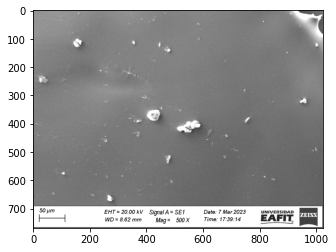

In [69]:
plt.imshow(sem_img, cmap='gray')

In [70]:
sem_img.shape

(768, 1024)

### Remove SEM label

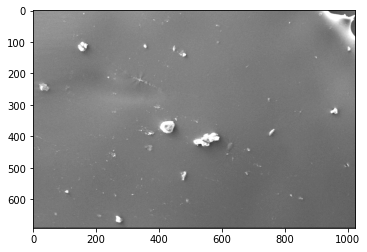

In [78]:
def remove_sem_label(img, crop_h: int =None):
    """
    This function removes the label in the bottom part of the image, SEM images are original squared,
    the label is at the bottom of the image.
    
    Args:
    img (numpy.ndarray): The input image.
    
    Returns:
    numpy.ndarray: sem image without the bottom label. 
    """
    if crop_h:
        h, w = img.shape
        output = img[:h - crop_h, :]
    else: #if micrograph is square
        h, w = img.shape
        output = img[:w, :]
    return output

img = remove_sem_label(sem_img, crop_h =77)#, (1024, 680))
#img = sem_img
plt.imshow(img, cmap='gray')

# Plotting histograms of image and equalization techniques

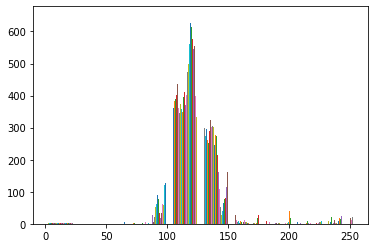

In [73]:
plt.hist(img)
plt.show()

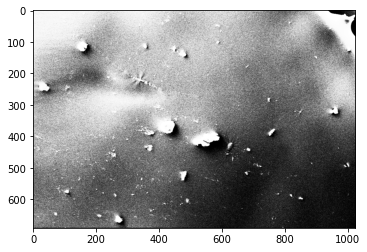

In [83]:
# create a CLAHE object (Arguments are optional).
# clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# cl1 = clahe.apply(img)

cl1 = cv.equalizeHist(img)

plt.imshow(cl1, cmap='gray')
plt.show()

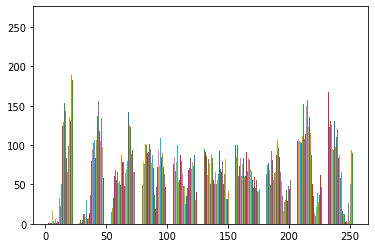

In [84]:
plt.hist(cl1)
plt.show()

In [86]:
img = cl1

# Testing different thresholding techniques to compare

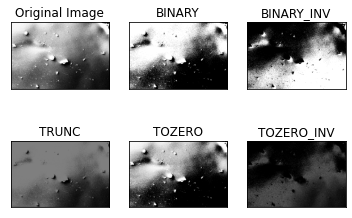

In [87]:
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

# Smoothing the image

In [81]:
def smooth_and_trhesh(img, kernel=None):
    """
    This function applies a smoothing filter to an image and then applies a binary inverse threshold to the filtered image.
    
    Args:
    img (numpy.ndarray): The input image.
    kernel (numpy.ndarray, optional): The smoothing filter to be applied. If not provided, a 5x5 average filter will be used.
    
    Returns:
    numpy.ndarray: The binary inverse thresholded image after smoothing.
    
    Example:
    >>> import cv2
    >>> img = cv2.imread("image.jpg", 0)
    >>> smooth_and_thresh(img)
    """
    if not kernel:
        # Creating the kernel with numpy
        kernel = np.ones((5, 5), np.float32)/25

    # Applying the filter
    smoothimg = cv.filter2D(src=img, ddepth=-1, kernel=kernel)
    _, smooththresh = cv.threshold(smoothimg, 160, 255, cv.THRESH_BINARY_INV)
    return smooththresh

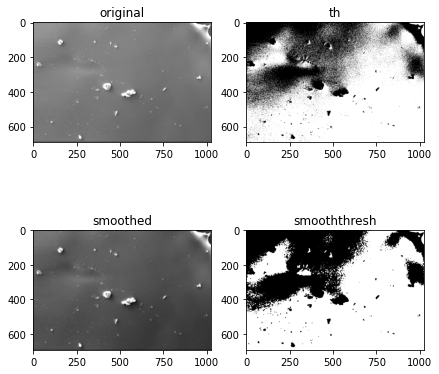

In [82]:
# Creating the kernel with numpy
kernel = np.ones((5, 5), np.float32)/25

 # Applying the filter
smoothimg = cv.filter2D(src=img, ddepth=-1, kernel=kernel)
_, smooththresh = cv.threshold(smoothimg, 127, 255, cv.THRESH_BINARY_INV)
# _, smooththresh = cv.threshold(smoothimg, 127, 255, cv.THRESH_BINARY)
 
# showing the image
axes= make_subplots(2,2, (7, 7))

for im, ax, t in zip([img,thresh2, smoothimg, smooththresh], axes, ['original', 'th','smoothed', 'smooththresh']):
    ax.imshow(im, cmap='gray')
    ax.set_title(t)


## Mophology DIP.
### Opening 
removes small dots (noise)
### Dilation
Dilate shape to fill geometry

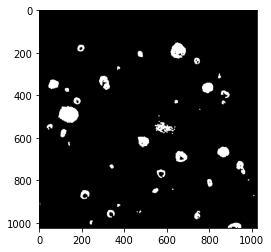

In [59]:
def apply_morph(img, dilate = 0, closing = 0 ): 
    """
    Applies morphological operations on an image using OpenCV library.

    Parameters:
        img (np.array): Input image
        dilate (int, optional): Number of iterations for dilation operation. Default is 0.
        closing (int, optional): Number of iterations for closing operation. Default is 0.

    Returns:
        np.array: The processed image.
    """
    
    open_k = np.ones((5, 5), np.uint8)
    close_k = np.ones((9,9), np.uint8)
    
    morphed = cv.morphologyEx(img, cv.MORPH_OPEN, open_k)  # opening removes small dots in the image.

    morphed = cv.dilate(morphed, open_k, iterations=dilate)  # dilatation increase mask size.

    for i in range(closing):
        morphed = cv.morphologyEx(morphed, cv.MORPH_CLOSE, close_k)
    
    return morphed
    
plt.imshow(apply_morph(smooththresh), cmap='gray')

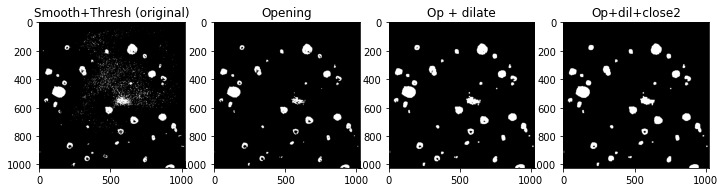

In [60]:
from skimage import morphology

open_k = np.ones((5, 5), np.uint8)
close_k = np.ones((9,9), np.uint8)
 
# The first parameter is the original image,
# kernel is the matrix with which image is
# convolved and third parameter is the number
# of iterations, which will determine how much
# you want to erode/dilate a given image.

axes = make_subplots(1, 4, figsize=(12, 8))

#img_erosion = cv.erode(smooththresh, kernel, iterations=1)

opening = cv.morphologyEx(smooththresh, cv.MORPH_OPEN, open_k)  # opening removes small dots in the image.

opdilated = cv.dilate(opening, open_k, iterations=1)  # dilatation increase mask size.

opdilclose = cv.morphologyEx(opdilated, cv.MORPH_CLOSE, close_k)
opdilclose2 = cv.morphologyEx(opdilclose, cv.MORPH_CLOSE, close_k)

for im, ax, title in zip([smooththresh, opening, opdilated, opdilclose2], axes,['Smooth+Thresh (original)','Opening', 'Op + dilate', 'Op+dil+close2']):
    ax.imshow(im, cmap='gray')
    ax.set_title(title)

mask = opdilclose #This technique returns the best mask

## Detect particles

In [61]:
from skimage.measure import label, regionprops

In [62]:
def detect_from_mask(im):
    """
    This function detects objects in an image given a binary mask. The binary mask
    is processed to obtain connected components, which are then used to draw bounding boxes
    around the objects. The function returns both the bounding boxes and the image with the
    bounding boxes drawn.
    
    Args:
    im (np.ndarray): A binary mask of the same size as the original image, with objects
                     represented as white pixels and background represented as black pixels.
                     
    Returns:
    list: A list of bounding boxes, each represented as a 4-tuple (y1, x1, y2, x2), where
          (y1, x1) and (y2, x2) are the (row, column) coordinates of the top-left and bottom-right
          corners of the bounding box, respectively.
    np.ndarray: The original image with the bounding boxes drawn.
    
    Example:
    >>> im = np.zeros((10, 10), dtype=np.uint8)
    >>> im[2:7, 2:7] = 255
    >>> boxes, display = detect_from_mask(im)
    >>> boxes
    [(2, 2, 7, 7)]
    >>> display.shape
    (10, 10)
    """
    lbl_0 = label(im) 
    props = regionprops(lbl_0)
    display = im.copy()
    boxes = []
    for ids, prop in enumerate(props):
        _ = cv.rectangle(display, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)
        _ = cv.putText(img = display,
                      text = str(ids),
                      org =  (prop.bbox[1], prop.bbox[0]),
                      fontFace = cv.FONT_HERSHEY_DUPLEX,
                      fontScale = 2.0,
                      color = (125, 246, 55),
                      thickness = 3)
        boxes.append(prop.bbox)
    
    return boxes, display

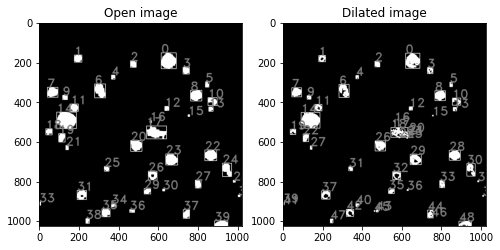

In [63]:
ax = make_subplots(1, 2, figsize = (8, 15))

_, im1 = detect_from_mask(mask)
bboxes, im2 = detect_from_mask(opening)
ax[0].imshow(im1, cmap='gray')
ax[0].set_title('Open image')
ax[1].imshow(im2, cmap='gray')
ax[1].set_title('Dilated image')
plt.show()


## Extract images

In [64]:
def points2bbox(points):
    """
    This function converts a set of points (y1, x1, y2, x1) representing a bounding box into the format
    (x, y, width, height), where (x, y) is the top-left corner of the bounding box.

    Args:
    points (tuple): A 4-tuple (y1, x1, y2, x2), where (y1, x1) and (y2, x2) are the 
                    (row, column) coordinates of the top-left and bottom-right corners
                    of the bounding box, respectively.

    Returns:
    tuple: A 4-tuple (x, y, width, height) representing the bounding box.
    """
    y1, x1, y2, x2 = points
    x = x1
    y = y1 
    w = x2 - x1
    h = y2 - y1
    return (x, y, w, h)


In [65]:
def crop_mask(sample, mask, square=True):
    """
    This function crops a sample image based on a given binary mask.
    
    Args:
    sample (numpy.ndarray): The input sample image.
    mask (numpy.ndarray): The binary mask used for cropping.
    square (bool, optional): If True, the output image will have a square shape. 
    If False, the output image will have the same shape as the mask. Default is True.
    
    Returns:
    numpy.ndarray: The cropped image.
    
    Example:
    >>> import numpy as np
    >>> sample = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> mask = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
    >>> crop_mask(sample, mask)
    array([[5]])
    """
    segmented = np.multiply(sample, mask)
    nzero = np.nonzero(segmented)
    top, bottom = np.min(nzero[0]), np.max(nzero[0])
    left, right = np.min(nzero[1]), np.max(nzero[1])
    
    if square:
        out = sample[top:bottom + 1, left:right + 1]
    else:
        out = segmented[top:bottom + 1, left:right + 1]
    return out

In [66]:
def crop_box(img, bbox):
    x, y, w, h = bbox
    crop = img[y:y+h,x:x+w]
    return crop

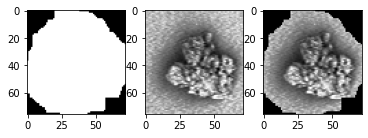

In [67]:
#for bbox in bboxes:
x,y,w,h = points2bbox(bboxes[0])
extract1 = mask[y:y+h,x:x+w] > 0.5
extract2 = img[y:y+h,x:x+w]
extract3 = crop_mask(extract2, extract1, False)
    
ax = make_subplots(1,3)

ax[0].imshow(extract1, cmap='gray')
ax[1].imshow(extract2, cmap='gray')
ax[2].imshow(extract3, cmap='gray')

    

## detected grid

IndexError: index 9 is out of bounds for axis 0 with size 9

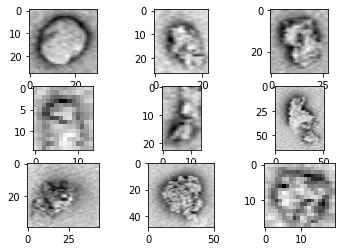

In [20]:
ax = make_subplots(3,3)
ax = ax.ravel()
for i, box in enumerate(bboxes):
    x,y,w,h = points2bbox(box)
    crop = img[y:y+h,x:x+w]
    ax[i-1].imshow(crop, cmap='gray')


## process a folder a write crops

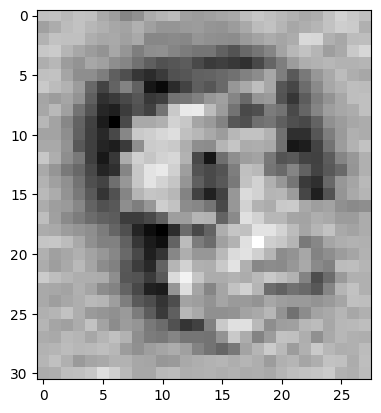

In [21]:
path= r'C:\Users\pc\Documents\Export2\OneDrive_2022-12-07\5 Agosto\EAFIT1 EAFIT0014.tif'
sem_img = cv.imread(path,0)
img = remove_sem_label(sem_img)

mask = smooth_and_trhesh(img)
mask = apply_morph(mask, dilate= 0, closing= 0)
bboxes, mask = detect_from_mask(mask)

i = 3
cropped = crop_box(img, points2bbox(bboxes[i]))

if False:
    cropped_mask = crop_box(mask, points2bbox(bboxes[i]))
    cropped = crop_mask(cropped, cropped_mask, square= False)

#cv.imwrite('test.png', cropped)


plt.imshow(cropped, cmap='gray')

### Floodfilling